In [1]:
import numpy as np
import pylab as py

### Powtórka
* klasyfikacja/regresja
* klasyfikacja:
  * regresja logistyczna
  * regraesja wieloraka
  * GAD i naiwny klasyfikator Bayesa
  

## Wstęp: Maszyny Wektorów Nośnych

* W tym wykładzie omówimy jeden z najbardziej popularnych algorytmów uczenia maszynowego: algorytm: Maszyny Wektorów Nośnych (ang. <i>Support Vector Machines</i> (SVM)).
* Bazuje on an koncepcji rozdzielenia danych należących do różnych klas możliwie dużą ”przerwą”. 
![](SVM1.png "By User:ZackWeinberg, based on PNG version by User:Cyc - This file was derived from:  Svm separating hyperplanes.png, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=22877598")

## Marginesy
* Aby wprowadzić tą koncepcję zajmiemy się najpierw wypracowaniem pojęcia marginesu.

* Zacznijmy od wyrobienia sobie intuicji co do pewności predykcji. 
* Rozważmy regresję logistyczną. 
  * Prawdopodobieństwo przynależności do klasy 1 $p(y=1|x;\theta )$ dane jest tu przez hipotezę $h_{\theta }(x) = g(\theta ^{T}x) = \frac{1}{1+ \exp (-\theta ^{T}x)}$.
  

  * Umówimy się, że klasę 1 przypiszemy danym $x$ jeśli $h_{\theta }(x) \ge 0.5$, 
    * to odpowiada $\theta ^{T}x \ge 0$ (w przeciwnym razie klasę 0).

  * Dla wektora $x$ z klasy 1 jesteśmy tym bardziej pewni jego przynależności do tej klasy, im większe będzie $h_{\theta }(x)$ czyli, czym większe będzie $\theta ^{T}x$. 
    * Tak więc dla $\theta ^{T}x \gg 0$ jesteśmy bardzo pewni, że $x$ należy do klasy 1, 
    * zaś dla $\theta ^{T}x \ll 0$ jesteśmy bardzo pewni, że $x$ należy do klasy 0.

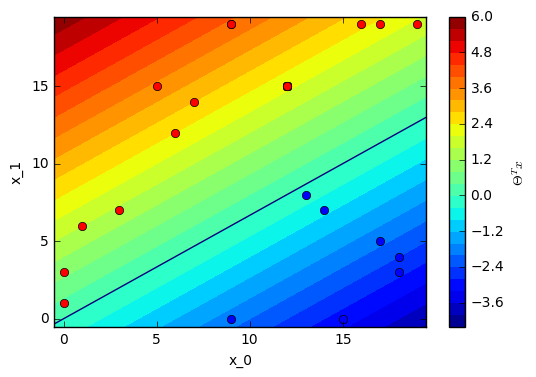

In [2]:
# ilustracja:
np.random.seed(0)
X = np.random.randint(20,size=(20,2))
theta = np.array([[-0.2],[0.3]])
Y = np.round( 1/(1+np.exp(np.dot(-X, theta))))
ind0 = np.where(Y==0)
ind1 = np.where(Y==1)
py.plot(X[ind0,0],X[ind0,1],'bo') 
py.plot(X[ind1,0],X[ind1,1],'ro')
py.xlabel("x_0")
py.ylabel("x_1")
# szykuję siątkę 
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# Obliczamy theta_t* x
Z = np.dot(np.c_[xx.ravel(), yy.ravel()],theta)
Z = Z.reshape(xx.shape)

py.contourf(xx,yy,Z,30) # rysuję kontur rozdzielający klasy
py.colorbar(label = "$\Theta^{T}x$")

py.contour(xx,yy,Z,0)
py.xlim(xx.min(), xx.max())
py.ylim(yy.min(), yy.max())
py.show()

Tak więc mając zbiór uczący wydaje się pożądane znalezienie takich parametrów $\theta $, że dla każdego elementu tego zbioru jeśli należy on do klasy 1 ($y^{(j)}=1$) to mamy $\theta ^{T}x^{(j)}\gg 0$, zaś jeśli należy on do klasy 0 ($y^{(j)}=0$) to mamy $\theta ^{T}x^{(j)}\ll 0$. Tą intuicję sformalizujemy za chwilę w postaci koncepcji marginesów funkcjonalnych.

Na zagadnienie klasyfikacji możemy też spojrzeć geometrycznie. Na zbiór uczący patrzymy jako na zbiór punktów w przestrzeni wejść oznaczonych etykietkami '1' lub '0'. Konstrukcja klasyfikatora polega na znalezieniu prostej (w dwóch wymiarach, w ogólności hiperpowierzchni) możliwie dobrze separującej elementy oznaczone różnymi etykietkami. Równanie hiperpowierzchni dane jest przez $\theta ^{T}x = 0$. Jeśli teraz dostaniemy nowy punkt $x$ do klasyfikacji to jesteśmy tym bardziej pewni decyzji, im dalej ten punkt leży od owej hiperpowierzchni. Zatem intuicyjnie wydaje się sensowne szukanie takiej hiperpowierzchni, aby elementy zbioru uczącego leżały możliwie daleko od niej. Tą intuicję sformalizujemy za chwilę w postaci koncepcji marginesów geometrycznych.

### Uwaga o notacji

Łatwiej będzie myśleć o hiprepowierzchniach jeśli listę parametrów $\theta $ rozdzielimy na $w$ i $b$ tak, że $\theta ^{T}x = w^{T}x + b$. W tej wersji notacji nie potrzebujemy też $x_{0}=1$.

Z kolei łatwiej będzie się liczyło jeśli zmienimy etykietki klas z '0' i '1' na '-1', '1'. Zatem na potrzeby opisu SVM przyjmiemy, że $y \in \lbrace -1,1\rbrace $.

Zamiast zwracać prawdopodobieństwa przynależności $x$ do klas, które musielibyśmy progować i następnie przydzielać $x$-om etykietki zastosujemy funkcję która od razu zwraca etykietki:

$\qquad 
h_{w,b}(x) = g(w^{T}x+b) = \left\lbrace  \begin{array} {rcl} 1 & dla & w^{T}x+b \ge 0 \\ -1 & dla & w^{T}x+b < 0 \\ \end{array} \right.
$

## Marginesy funkcjonalne i geometryczne

### Marginesy funkcjonalne

Dla przykładu ze zbioru uczącego $(x^{(j)},y^{(j)})$ definiujemy margines funkcjonalny jako:

$\qquad 
\hat{\gamma }^{(j)} = y^{(j)}(w^{T}x^{(j)} + b)
$

Zauważmy, że:
* dla $y^{(j)}=1$ mamy duży margines funkcjonalny jeśli $w^{T}x^{(j)} +b$ jest dużą dodatnią liczbą. 
* dla $y^{(j)}=-1$ mamy duży margines funkcjonalny jeśli $w^{T}x^{(j)} +b$ jest dużą ujemną liczbą. 
    (-> rzućmy okiem na rys.)
* Ponadto jeśli klasyfikacja jest prawidłowa to margines funkcjonalny jest dodatni. 

A zatem dobre parametry $w$ i $b$ powinny dawać duże wartości marginesów funkcjonalnych. 

> Jedynym problemem takiej definicji marginesów funkcjonalnych jest to, że można je uczynić dowolnie dużymi przez przemnożenie $w$ i $b$ przez odpowiednio dużą liczbę. 

Wydaje się zatem rozsądne aby do powyższej definicji dodać warunek normalizacji zamieniając $(w,b)$ na $\left( \frac{w}{||w||},\frac{b}{||w||}\right)$.

### Margines funkcjonalny dla zbioru uczącego
Definicję marginesu funkcjonalnego dla całego zbioru uczącego otrzymujemy wybierając najgorszy przypadek spośród wszystkich marginesów funkcjonalnych dla poszczególnych elementów zbioru:

$\qquad 
\hat{\gamma }= \min _{j=1,\dots ,m} \hat{\gamma }^{(j)}
$

### Marginesy geometryczne

* Margines geometryczny $\gamma ^{(j)}$ to odległość danego punktu $x^{(j)}$ od hiperpowierzchni rozdzielającej. 
* Aby ją znaleźć trzeba obliczyć długość wektora prostopadłego do hiperpowierzchni, o który należy przesunąć punkt $x^{(j)}$ aby znalazł się on na hiperpowierzchni. 
* Jednostkowy wektor prostopadły do hiperpowierzchni ma współrzędne: $\frac{w}{||w||}$. Przesunięcie punktu $x^{(j)}$ w kierunku tego wektora otrzymujemy jako $x^{(j)} + \alpha \frac{w}{||w||}$. 
* Jeśli nasz przesunięty punkt ma się znaleźć na hiperpowierzchni separującej to musi spełniać jej równanie (długość tego wymaganego przesunięcia to poszukiwany margines geometryczny $\gamma ^{(j)}$). 
* Dla przypadku $y^{(j)}=1$ mamy:

$\qquad 
w^{T}\left(x^{(j)} - \gamma ^{(j)} \frac{w}{||w||} \right) +b=0
$

Rozwiązując to równanie ze względu na $\gamma ^{(j)}$ dostajemy:

$\qquad 
\gamma ^{(j)} = \frac{w^{T}x^{(j)} +b}{||w||} = \left( \frac{w}{||w||} \right)^{T} x^{(j)}+\frac{b}{||w||}
$

* Przypadek $x^{(j)}$ z klasy $y^{(j)} = -1$ wymagałby przesunięcia w kierunku zgodnym z wektorem normalnym do hiperpowierzchni. 
* Czyli aby uwzględnić oba przypadki jednocześnie możemy zapisać:

$\qquad 
\gamma ^{(j)} = y^{(j)}\left( \left(\frac{w}{||w||}\right)^{T}x^{(j)} + \frac{b}{||w||}\right)
$

Zauważmy, że dla znormalizowanego $w$ ($||w||=1$) dostajemy, że margines funkcjonalny równy jest marginesowi geometrycznemu. 

I podobnie jak dla marginesów funkcjonalnych, definiujemy margines geometryczny względem zbioru uczącego jako najgorszy przypadek:

$\qquad 
\gamma = \min _{j=1,\dots ,m} \gamma ^{(j)}
$

## Klasyfikator optymalny pod względem marginesów -

## podstawowa wersja SVM

Chwilowo zajmiemy się tylko problemami liniowo separowalnymi.

W języku wprowadzonych powyżej definicji możemy powiedzieć, że optymalny jest ten klasyfikator, który daje możliwie największy margines geometryczny (wtedy dane ze zbioru uczącego rozseparowane są przerwą o szerokości co najmniej dwóch marginesów).

> Jak wyznaczyć jego parametry?

### Wersja 1
Dla ustalonego zbioru uczącego możemy sformułować następujący problem optymalizacyjny:

$\qquad \begin{matrix}
\max _{\gamma ,w,b} \gamma && \\
&\textrm {p.w.:} &y^{(j)}(w^{T}x^{(j)}+b) \ge \gamma , \; j = 1,\dots ,m \\
&&||w|| =1
\end{matrix}$

* oznacza to, że chcemy zmaksymalizować $\gamma $ ale pod warunkiem, że margines funkcjonalny dla każdego przykładu ze zbioru uczącego jest nie mniejszy niż $\gamma $. 
* Dodatkowy warunek $||w||=1$ z jednej strony gwarantuje, że nie osiągniemy poprzedniego warunku przez przeskalowanie parametrów w marginesie funkcjonalnym, a z drugiej strony gwarantuje, że marginesy funkcjonalne i geometryczne są sobie równe.

> Taka formulacja problemu optymalizacyjnego jest jednak bardzo niewygodna. W szczególności warunek $||w||=1$ powoduje, że problem nie jest wypukły (cechą wypukłych problemów optymalizacyjnych jest to, ze mają jedno ekstremum, zatem jest to ekstremum globalne).

### Wersja 2
Spróbujmy zatem przeformułować ten problem. Skorzystajmy z zależności między marginesem funkcjonalnym a geometrycznym: $\gamma = \hat{\gamma }/||w||$. Rozważmy:


$\begin{matrix}
\max _{\gamma ,w,b} \frac{\hat{\gamma }(w,b)}{||w||}&& \\
&\textrm {p.w.:} &y^{(j)}(w^{T}x^{(j)}+b) \ge \hat{\gamma }, \; j = 1,\dots ,m\end{matrix}$

* chcemy znaleźć parametry maksymalnego znormalizowanego marginesu funkcjonalnego. 
* Pozbyliśmy się dzięki temu niewygodnego warunku $||w||=1$, ale za to mamy niewygodną funkcję celu. 
 
 > Musimy jeszcze trochę popracować.

### Z własności marginesów ...
Pamiętamy, że skalując współczynniki $w$ i $b$ możemy uzyskać dowolną wartość marginesu funkcjonalnego. Weźmy zatem takie skalowanie, żeby dla zadanego zbioru uczącego otrzymać:

$\qquad 
\hat{\gamma }=1
$

Możemy takie skalowanie zapewnić, bo gdybyśmy znali jakieś $w$ i $b$ będące rozwiązaniem problemu optymalizacyjnego, które dają margines funkcjonalny $\gamma ^{*}$ to dzieląc to $w$ i $b$ przez $\gamma ^{*}$ dostajemy margines funkcjonalny równy 1.

### Obserwacje 
Wstawmy zatem $\hat{\gamma }= 1$ do formulacji (2):

$\qquad \begin{matrix}
\max _{w,b} \frac{1}{||w||}&& \\
&\textrm {p.w.:} &y^{(j)}(w^{T}x^{(j)}+b) \ge 1, \; j = 1,\dots ,m
\end{matrix}$

Zauwżmy, że:

$\qquad 
\max _{w,b} \frac{1}{||w||} = \min _{w,b} ||w||=\min _{w,b}||w||^{2}
$

### Wersja 3
Dzięki tej obserwacji możemy nasz problem optymalizacyjny zapisać w wygodnej formie:

$\qquad \begin{matrix}
\min _{w,b} ||w||^{2}&& \\
&\textrm {p.w.:} &y^{(j)}(w^{T}x^{(j)}+b) \ge 1, \; j = 1,\dots ,m
\end{matrix}$

* funkcja celu jest funkcją wypukłą i w związku z tym posiada dokładnie jedno minimum, zatem jest to minimum globalne. 
* Co więcej do przeprowadzenia takiej minimalizacji wypukłej z więzami istnieje wiele gotowych bibliotek numerycznych.

## Dygresja
W zasadzie w tym miejscu można by powiedzieć, że mamy rozwiązany problem.

Zrobimy jednak w tym miejscu dygresję o mnożnikach Lagrangea, które to pozwolą na uzyskanie jeszcze dogodniejszej postaci problemu i rozszerzenia metody SVM na bardzo wielowymiarowe wektory cech.

## Mnożniki Lagrangea

Metoda mnożników Lagrangea jest ogólnym sposobem rozwiązywania problemów optymalizacyjnych z więzami. Mogliście już o niej słyszeć np. na mechanice klasycznej.

Dla przypomnienia:
Niech nasz problem optymalizacyjny będzie dany przez:


$\begin{matrix}
\min _{w}f(w)&\\
\textrm {p.w.: }&h_{i}(w) =0, i =1,\dots ,l
\end{matrix}$


Aby go rozwiązać budujemy tzw. lagrangian:

$\qquad 
\mathcal {L}(w,\beta ) = f(w) + \sum _{i=1}^{l} \beta _{i}h_{i}(w)
$

współczynniki $\beta _{i}$ to właśnie mnożniki Lagrangea. 

Rozwiązaniem wspomnianego wyżej problemu minimalizacyjnego jest rozwiązanie równań:

$\qquad 
\frac{\partial \mathcal {L}}{\partial w_{i}} = 0; \quad \frac{\partial \mathcal {L}}{\partial \beta _{i}} = 0
$

Podejście to można rozszerzyć na problemy optymalizacyjne posiadające więzy w postaci nierówności, tzn takich jak poniższy:


$\begin{matrix}
\min _{w} = f(w) && \\
\textrm {pod warunkiem:} & g_{i}(w)\le 0 , &i = 1,\dots ,k \\
& h_{i} (w) = 0 ,& i = 1,\dots , l
\end{matrix}$

![](Inequality_constraint_diagram.png)

Aby rozwiązać ten problem musimy najpierw zdefiniować uogólniony lagrangian z mnożnikami $\alpha _{i}$ i $\beta _{i}$:

$\qquad 
\mathcal {L}(w,\alpha ,\beta ) = f(w) + \sum _{i=1}^{k} \alpha _{i}g_{i}(w) + \sum _{i=1}^{k} \beta _{i}h_{i}(w)
$

### Problem pierwotny
Rozważmy wielkość $\theta _{p}(w)$ zdefiniowaną:

$\qquad 
\theta _{p}(w) = \max _{\alpha ,\beta :\alpha _{i} \ge 0} \mathcal {L}(w,\alpha ,\beta )
$

Ma ona tę własność, że jeśli któryś z warunków nie jest spełniony to wybucha ona do nieskończoności (np. dla $g_{3}(w)>0$ maksymalizacja $\theta _{p}$ po parametrze $\alpha _{3}$ dałoby $\alpha _{3} = \infty $ a co za tym idzie cały $\mathcal {L} = \infty $. Podobnie dla naruszenia warunku $h_{i}(w) = 0$ dla jakiegoś $i$ spowoduje, że odpowiednie $\beta _{i} = \infty $ i $\mathcal {L} = \infty $.) Natomiast jeśli wszystkie warunki są spełnione to $\theta _{p} = f(w)$:

$\qquad 
\theta _{p} = \left\lbrace 
\begin{array}{ll}
f(w)& \textrm {jesli } w \textrm { spełnia warunki} \\
\infty &\textrm {w przeciwnym wypadku}
\end{array}
\right.
$

Zatem rozwiązanie naszego pierwotnego problemu $p^{*}$ może być zapisane w zwarty sposób tak:

$\qquad 
p^{*} = \min _{w} \theta _{p}(w) = \min _{w} \max _{\alpha ,\beta : \alpha _{i }\ge 0 } \mathcal {L}(w,\alpha ,\beta )
$

### Problem dualny
A teraz przyjrzyjmy się innemu problemowi, który nazywa się dualnym do pierwotnego.
Definiujemy wielkość $\theta _{d}$:

$\qquad 
\theta _{d} (\alpha ,\beta ) = \min _{w} \mathcal {L}(w,\alpha ,\beta )
$

O ile wielkość $\theta _{p}$ była wartością lagrangianu zmaksymailzowanego względem $\alpha $ i $ \beta $ to
wielkość $\theta _{d}$ jest wartością tego lagrangianu zminimalizowanego po $w$. Dualny problem optymalizacyjny polega na znalezieniu takiego $d^{*}$, że:

$\qquad 
d^{*} = \max _{\alpha ,\beta : \alpha
_{i}\ge 0} \theta _{d} = \max _{\alpha ,\beta : \alpha _{i}\ge 0} \min _{w} \mathcal {L}(w,\alpha ,\beta )
$

Widać, że problem pierwotny różni się od dualnego kolejnością operacj max i min. Można też zauważyć, że w ogólności zachodzi relacja:

$\qquad 
d^{*} = \max _{\alpha ,\beta : \alpha _{i}\ge 0} \min _{w} \mathcal {L}(w,\alpha ,\beta ) \le \min _{w} \max _{\alpha ,\beta : \alpha _{i}\ge 0} \mathcal {L}(w,\alpha ,\beta ) =p^{*}
$
### Na przykład:
$\max_{y\in\{0,1\}}(\min_{x\in\{0,1\}}1\{x==y\})$ 

$\min_{x\in\{0,1\}}(\max_{y\in\{0,1\}}1\{x==y\})$

### Kiedy te problemy mają to samo rozwiązanie?
Pod pewnymi warunkami zachodzi nawet coś ciekawszego a mianowicie:

$\qquad 
d^{*} = p^{*}
$

czyli zamiast rozwiązywać pierwotny problem, możemy rozwiązać problem dualny i stwierdzić, że jest on rozwiązaniem problemu pierwotnego.

Równość ta zachodzi pod następującymi warunkami: 
* $f$ i $g_{i}$ muszą być wypukłe, 
* $h_{i}$ muszą być afiniczne (tzn. postaci $h_{i}(w) = a_{i}^{T}w + b_{i}$), 
* oraz dla pewnego $w$ zachodzi $g_{i}(w) <0$. 
Pod tymi warunkami istnieją $w^{*},\alpha ^{*},\beta ^{*}$,
dla których $p^{*}=d^{*}=\mathcal {L} (w^{*},\alpha ^{*},\beta ^{*})$.
Ponadto $w^{*},\alpha ^{*},\beta ^{*}$ spełniają:

warunki Karush-Kuhn-Tucker'a (KKT):

$\begin{matrix}
\frac{\partial }{\partial w_{i}} \mathcal {L} (w^{*},\alpha ^{*},\beta ^{*})&=& 0 , \quad i = 1,\dots ,k \\
\frac{\partial }{\partial \beta _{i}} \mathcal {L} (w^{*},\alpha ^{*},\beta ^{*})&=& 0 , \quad i = 1,\dots ,l \\
\alpha _{i}^{*} g_{i}(w^{*}) &=&0, \quad i = 1,\dots ,k \\
g_{i}(w^{*}) &\le & 0, \quad i =1,\dots ,k \\
\alpha ^{*} &\ge & 0, \quad i=1,\dots ,k
\end{matrix}$

* Pierwsze dwie równości zapewniają byćie w ekstremum Lagrangianu 
* trzecia zapewnia, że dla więzów aktywych $g_i$ $\alpha_i$ jest zerowa.
* nierówność cztery zapewnia, że nie naruszamy warunków problemu
* ostatnia nierówność zapewnia, że nie zmienimy zwrotów nierówności w warunkach problemu

Prawdziwe jest też twierdzenie odwrotne. Jeśli jakieś parametry $w^{*},\alpha ^{*},\beta ^{*}$ spełniają warunki KKT to są też rozwiązaniem problemu pierwotnego i dualnego.

Zwróćmy uwagę na warunek $\alpha _{i}^{*} g_{i}(w^{*})=0$. Mówi on tyle, że jeśli dla jakiegoś $i$ $\alpha_{i}>0$ to $g_{i}(w^{*}) =0$. Warunek ten przyda się później do pokazania, że wektorów nośnych w SVM jest niewiele i do pokazania zbieżności wydajnego algorytmu budowania SVM.



Kuhn, H. W.; Tucker, A. W. Nonlinear Programming. Proceedings of the Second Berkeley Symposium on Mathematical Statistics and Probability, 481--492, University of California Press, Berkeley, Calif., 1951. http://projecteuclid.org/euclid.bsmsp/1200500249.